# RSA-UID-switchbaord

Investigating (possibly) meaningful disfluencies in switchboard

### Objectives
1. analysis: do disfluencies appear before high-surprisal items?
2. listener exp: are listeners inclined to choose high-surprisal items as good candidates when they see 'uh'

### Resources
* Switchboard http://www.nltk.org/_modules/nltk/corpus/reader/switchboard.html
* typing animation https://codepen.io/rusjames/pen/uAFhE

In [169]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from nltk.corpus import switchboard as sb
import numpy as np
import pandas as pd
import pdb
import random
import re
import seaborn as sns

%matplotlib inline  

Example discourse...

In [2]:
discourses = [d for d in sb.discourses()]

In [3]:
discourses[0][:5]

[<A.1: 'Uh , do you have a pet Randy ?'>,
 <B.2: 'Uh , yeah , currently we have a poodle .'>,
 <A.3: 'A poodle , miniature or , uh , full size ?'>,
 <B.4: "Yeah , uh , it 's , uh miniature .">,
 <A.5: 'Uh-huh .'>]

### Preprocessing helpers

In [4]:
def replace_start(s):
    start_patt = r"^<[AB]\.[0-9]{1,}:\s[\'\"]"
    replace_patt = ''
    s = re.sub(start_patt, replace_patt, s)
    return s

def replace_end(s):
    end_patt = r"\s?\'?>"
    replace_patt = ''
    s = re.sub(end_patt, replace_patt, s)
    return s

def remove_punct(s):
    s = re.sub('[,\.\?:\{\}\[\]]', '', s)
    return s

def turn2Str(t):
    unicodeStr = t.unicode_repr()
    s = preprocess_turn_str(unicodeStr)
    return s

def preprocess_turn_str(s):
    s = replace_start(s)
    s = replace_end(s)
    s = remove_punct(s)
    s = s.lower()
    s = re.sub('\s{2,}', ' ', s)
    s = re.sub(r'"$', '', s)
    s = s.rstrip()
    return s

check...

In [5]:
exTurn = discourses[0][2]
print(str(exTurn))
turn2Str(exTurn)

<A.3: 'A poodle , miniature or , uh , full size ?'>


'a poodle miniature or uh full size'

## Data

In [30]:
def removeUhs(s):
    uh_patt = r'\suh\s'
    return re.sub(uh_patt, ' ', s)
# removeUhs('a poodle miniature or uh full size')

'a poodle miniature or full size'

In [31]:
allStrs = [turn2Str(t) for d in discourses for t in d]
allStrsStartEnd = ['^ ' + s + ' $' for s in allStrs]
allStrsNoUhs = [removeUhs(s) for s in allStrsStartEnd]
orderedTokensAll = ' '.join(allStrsStartEnd).split(' ')
orderedTokensNoUhs = ' '.join(allStrsNoUhs).split(' ')

### LM

In [118]:
class Ngram:
    def __init__(self, n=2):
        self.n = n
        self.vocab_size = 0
        
    def ingest(self, orderedTokens):
        self.vocab_size = len(orderedTokens)
        d = defaultdict(Counter)
        for i, word in enumerate(orderedTokens):
            if i == len(orderedTokens)-self.n:
                break
            currTup = tuple(orderedTokens[i:i+self.n-1])
            d[currTup][orderedTokens[i+self.n-1]] += 1
        self.lm = d
        
    def get_lm(self):
        return self.lm
    
    def get_candidates(self, token):
        return self.lm[token]
    
    def get_cond_prob(self, tup):
        context = tup[0:self.n-1]
        target = tup[self.n-1]
        num = self.lm[context][target]
        denom = np.sum([d[1] for d in self.lm[context].items()])
        return num / denom if denom != 0 else 0.0
    
    def get_cond_count(self, tup):
        context = tup[0:self.n-1]
        target = tup[self.n-1]
        num = self.lm[context][target]
        return num      
        

check...

In [117]:
ng2 = Ngram(n=2)
ng3 = Ngram(n=3)
exCorpus = ['apple', 'on', 'the', 'apple', 'on', 'a', 'range', 'apple']
ng2.ingest(exCorpus)
ng3.ingest(exCorpus)
ng2.get_cond_count(('on', 'apple'))
ng3.get_cond_count(('on', 'the', 'apple'))

1

## Reproducing Levy & Jaeger (2007) that-omission analysis (section 4)

**Objective**:
What is the relationship between `uh/um` presence and the informativity of the following text?
* H_0: there is no relationship
* H_1: presence of `uh/um` indicates the following content is high-surprisal.

In [209]:
ng_all = Ngram(n=3)
ng_all.ingest(orderedTokensAll)
ng_no_uh = Ngram(n=2)
ng_no_uh.ingest(orderedTokensNoUhs)

In [210]:
uhStrs = [s for s in allStrsStartEnd if 'uh' in s.split()]
uhStrs[0]

'^ uh do you have a pet randy $'

In [211]:
def getKtuple(s, k=2):
    s_split = s.split(' ')
    d = []
    for i, token in enumerate(s_split):
        if i == len(s_split)-k:
            break
        curr_tup = tuple(s_split[i:i+k])
        d.append(curr_tup)
    return d

# getKtuple(uhStrs[0])

In [212]:
def getSentProbs(s, model, n):
    d = {}
    for tup in getKtuple(s, n):
        d[tup] = model.get_lm_prob(tup)
    return d

# getSentProbs(removeUhs(uhStrs[0]), ng_no_uh, n)

### Todo

* Get all instances of find all context / targets (w/ and w/o disfluencies and get surprisal)

In [213]:
d = []
for s in uhStrs:
    three_tuples = getKtuple(s, 3)
    for i, k in enumerate(three_tuples):
        if k[1] == 'uh' and sum([i == 'uh' for i in k]) == 1:
            before = k[0]
            after = k[2]
            t = (before, after)
            non_uh_cnt = ng_no_uh.get_cond_count(t)
            uh_cnt = ng_all.get_cond_count(k)
            if uh_cnt > non_uh_cnt:
                pdb.set_trace()
            lik = uh_cnt / non_uh_cnt
            surp = np.log2(ng_no_uh.get_cond_prob(t))
            data = {
                'before': before,
                'after': after,
                'lik': lik,
                'supr': surp,
                'total':non_uh_cnt
            }
            d.append(data)

In [214]:
df = pd.DataFrame(d).drop_duplicates()
# df.to_csv('switchboard-uh-data-20171214.csv')

In [215]:
df

,after,before,lik,supr,total
0,do,^,0.047619,-7.980276,21
1,yeah,^,0.016477,-2.748712,789
2,full,or,1.000000,-8.370687,1
3,it,yeah,0.076923,-4.723026,39
4,miniature,'s,1.000000,-10.342075,1
5,around,dogs,1.000000,-2.000000,1
6,i,n't,0.076923,-4.917946,26
7,i,dog,0.333333,-2.115477,3
8,it,but,0.083333,-3.502500,48
9,definitely,it,1.000000,-10.705632,1


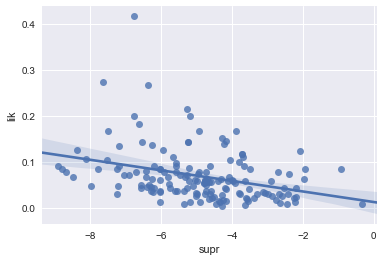

In [216]:
sns.regplot(x='supr', y='lik', data=df[df['total']>10])

## Experiment - brainstorm

* Task: sentence completion - particiants see a sentence fragment and have to fill in the missing item from a choice of five candidates. 
    + include the "true" candidate?
    + include a spectrum of high->low suprisal items
* What if we had people incrementally build sentences from the LM candidates?
    

In [220]:
ng = Ngram(2)
ng.ingest(orderedTokensAll)

In [229]:
# sent = random.choice(allStrs).split(' ')
# index = random.randint(0, len(sent))
# sent[:index]
exSent = 'yeah i have a uh well a mutt myself i call it a uh uh chowperd'
exSentSplit = exSent.split(' ')
index = random.randint(1, len(exSentSplit)-1)
fragment = exSentSplit[:index]

In [230]:
lastToken = fragment[-1]
print(lastToken)
trueCandidate = exSentSplit[index]

well


In [231]:
lm_candidates = list(ng.get_candidates((lastToken,)).keys())
print(lm_candidates)
candidates = set(random.sample(lm_candidates, min(5, len(lm_candidates)))) | {trueCandidate}

['um', 'it', 'about', 'uh', 'a', 'that', 'my', '$', 'randy', 'i', 'probably', 'well', 'actually', 'thank', 'yes', 'there', 'and', 'do', 'anyway', 'you', 'we', 'not', 'frankly', 'they', 'see', 'yeah', 'so', 'have', 'this', 'okay', 'the', '--', 'your', 'whatever', 'if', 'whose', 'good', 'commit', 'thanks', 'he', 'iraq', 'since', 'is', 'here', 'no', 'colorado', 'even', 'now', 'girls', 'to', 'our', 'because', 'let', 'ho', 'penicillin', 'what', 'maybe', 'wonder', 'sometimes', 'potential', 'as', 'becau-', 'look', 'when', 'none', 'she', 'presentation', 'like', 'but', 'jean', 'up', 'every', 'transmissions', 'then', 'any', 'course', 'social', 'knock', 'does', 'drugs', 'tur', 'h-', 'in', 'phrased', 'with', 'can', 'perceived', 'me', 'nice', 'heart', 'being', 'of', 'how', 'supported', 'at', 'forget', 'basically', 'for', 'sounds', 'jeez']


In [232]:
print("Full utterace:\t{}".format(exSent))
print('Fragment:\t{}'.format(' '.join(fragment)))
print('Last token:\t{}'.format(lastToken))
print('Candidates:\t{}'.format(candidates))
print('True candidate:\t{}'.format(trueCandidate))

Full utterace:	yeah i have a uh well a mutt myself i call it a uh uh chowperd
Fragment:	yeah i have a uh well
Last token:	well
Candidates:	{'i', 'they', 'a', 'of', 'knock', 'now'}
True candidate:	a


## Experiment - just "uh's"

In [233]:
uhStrs = [s for s in allStrsStartEnd if 'uh' in s.split()]
uhStrs_sample = random.sample(uhStrs, 10)
uhStrs_sample[0]

'^ but really uh what do you feel the changes in the future like with the abortions and that type of thing women in politics and -- $'

In [234]:
def get_match_indices(x, s):
    return [i for i, w in enumerate(s.split(' ')) if w == x]

In [235]:
indices = get_match_indices('uh', uhStrs_sample[0])
index = indices[0]; index

3

In [236]:
' '.join(uhStrs_sample[0].split(' ')[0:index+1])

'^ but really uh'

In [237]:
class categoricalDistr:
    def __init__(self, vs, ps):
        self.vs = vs
        self.ps = ps
        self.normed_ps = self.normalize(self.ps)
        self.distr = dict(zip(self.vs, self.normed_ps))
        
    def sample(self, k=5):
        vals = np.random.choice(a=self.vs, size=(k), p=self.normed_ps)
        d = {}
        for v in vals:
            d[v] = self.distr[v]
        return d

    def normalize(self, x):
        return x / np.sum(x)
        


In [241]:
vs = list(ng.get_candidates(('uh',)).keys())
ps = list(ng.get_candidates(('uh',)).values())
C = categoricalDistr(vs, ps)

In [242]:
C.sample()

{'a': 0.031620553359683792,
 'as': 0.0031620553359683794,
 'but': 0.0094861660079051391,
 'is': 0.003952569169960474,
 'they': 0.020553359683794466}